In [1]:
%load_ext skip_cell

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt

In [3]:
IMPATIENCE = True

If `SAMPLE` is `None` the entire dataset will be used during training.
`N_CHANNELS` controls the number of channels in images (for `grayscale` use `1`, for `RGB` use `3`).
`EXPERIMENT_NAME` defines the name of a file that stores information about results of Bayesian optimization of hyperparameters.

In [4]:
SAMPLE = None
N_CHANNELS = 1
EXPERIMENT_NAME = 'shallow_clf_tpe_pipeline_cpu_overfit_penalty'

# Data preparation

We start from loading data into memory.

In [5]:
from tmle.dataloaders import ImageFoldersDataset

Images (both in training and test sets) have different, unregular sizes. Thus, we will use transformations that will first scale the images and then crop (randomly) a square-shaped fragments. After that, images will be converted to `torch.Tensors`.

Note that:

* `transforms.Resize` will resize the input PIL Image to given size. If size is an int, smaller edge of the image will be mathced to this number, ie. if `height > width`, then image will be rescaled to `(size * height / width, size)`,
* `transforms.RandomCrop` will crop the given PIL Image at a random location. If size is an int instead of sequence like `(height, width)`, a square crop `(size, size)` is made.

In [6]:
from torchvision import transforms

simple_transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize(32),
    transforms.RandomCrop(32),
    transforms.ToTensor()
])

Then, we will create an object that will allow us to load images in *mini-batches*. For each channel (or a single channel in case of grayscale images) we will calculate mean and standard deviation. This values will be used to normalize the input data.

In [7]:
dataset = ImageFoldersDataset(
    path_to_data='../data/cpu/train',
    transform=simple_transform
)

Notice that even for small images, ie. `(224, 224, 3)` calculating means of each channel requires performing operations on vectors of sizes: `n_samples * 224 * 224 * 3` (on an ordinary laptop problems with lack of memory may occur). Thus, for benchmark purposes we used smaller images with output shape of `(32, 32, 1)`.

In [8]:
%%time
from collections import defaultdict

means, stds = defaultdict(list), defaultdict(list)
counter = 0
for data in dataset.loader(batch_size=170):
    images, _ = data
    for channel in list(range(N_CHANNELS)):
        means[channel].append(images[:, channel, :, :].mean().item())
        stds[channel].append(images[:, channel, :, :].std().item())
    counter += 1
    if counter % 10 == 0:
        print('Mean calculated for {n} batches'.format(n=counter / (17000 / 170)))
# save means and stds
means = [np.mean(means[channel]) for channel in list(range(N_CHANNELS))]
stds = [np.mean(stds[channel]) for channel in list(range(N_CHANNELS))]

Mean calculated for 0.1 batches
Mean calculated for 0.2 batches
Mean calculated for 0.3 batches
Mean calculated for 0.4 batches
Mean calculated for 0.5 batches
Mean calculated for 0.6 batches
Mean calculated for 0.7 batches
Mean calculated for 0.8 batches
Mean calculated for 0.9 batches
Mean calculated for 1.0 batches
CPU times: user 35.3 s, sys: 1.05 s, total: 36.4 s
Wall time: 37.4 s


Then, we add a transformation that normalizes the input images and load into memory the number of images defined in a variable `SAMPLE` (or the entire dataset if `SAMPLE` is `None`.

In [9]:
simple_transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize(32),
    transforms.RandomCrop(32),
    transforms.ToTensor(),
    transforms.Normalize(mean=means, std=stds)
])

In [10]:
dataset_normalized = ImageFoldersDataset(
    path_to_data='../data/cpu/train/',
    transform=simple_transform
)
if SAMPLE:
    X_train, y_train = dataset_normalized.load_all_images(img_shape=(32, 32, 1))
    random_sample_idx = np.random.randint(low=0, high=len(X_train), size=SAMPLE)
    X_train, y_train = X_train[random_sample_idx], y_train[random_sample_idx]
else:
    X_train, y_train = dataset_normalized.load_all_images(img_shape=(32, 32, 1))

***Important note about reproducibility***.

Completely reproducible results are not guaranteed across PyTorch releases, individual commits or different platforms. Furthermore, results need not be reproducible between CPU and GPU executions, even when using identical seeds.

However, in order to make computations deterministic on specific problem on one specific platform and Pytorch release, there are a couple of steps to take.

There are two pseudorandom number generators involved in PyTorch, which we had to seed manually to made runs reproducible. We implemented `tmle.dataloaders.ImageFolderDataset` setting seed as follows:

    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

# Shallow Classifier

In [11]:
from sklearn.pipeline import Pipeline
from tmle.transformers import HOGTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

Classes are imbalanced.

In [12]:
np.bincount(y_train.astype('int64')) / y_train.shape[0]

array([0.11176471, 0.11176471, 0.22941176, 0.11176471, 0.05294118,
       0.11176471, 0.05294118, 0.05294118, 0.11176471, 0.05294118])

We start with the definition of a simple `Pipeline`. It will be used for presentation purposes. With ***default*** values of *hyperparameters* we encounter a problem of overfitting.

In [13]:
pipeline = Pipeline(steps=[
    ('hog', HOGTransformer(
        img_shape=(32, 32),
        orientations=9,
        pixels_per_cell=(8, 8),
        cells_per_block=(2, 2))
    ),
    ('scaler', StandardScaler()),
    ('svm', LinearSVC())
])

Fit `pipeline` to training set.

In [14]:
%%time
pipeline.fit(X_train, y_train)

CPU times: user 2min 27s, sys: 1.45 s, total: 2min 28s
Wall time: 2min 37s


/Users/lukaszambroziak/anaconda3/envs/tmle/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Pipeline(memory=None,
     steps=[('hog', HOGTransformer(block_norm='L2-Hys', cells_per_block=(2, 2),
        feature_vector=True, img_shape=(32, 32), multichannel=None,
        orientations=9, pixels_per_cell=(8, 8), transform_sqrt=False,
        visualize=False)), ('scaler', StandardScaler(copy=True, with_mean=True, with_st...ax_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0))])

Make predictions on training set.

In [15]:
%%time
y_train_preds = pipeline.predict(X_train)

CPU times: user 7.08 s, sys: 31.3 ms, total: 7.12 s
Wall time: 7.12 s


Measure performance with `balanced_accuracy_score` and prepare `classification_report`.

In [16]:
from sklearn.metrics import accuracy_score, classification_report, balanced_accuracy_score

print('Accuracy: {acc:.5f}. Balanced accuracy: {bal_acc:.5f}'.format(
    acc=accuracy_score(y_train, y_train_preds),
    bal_acc=balanced_accuracy_score(y_train, y_train_preds)
))

Accuracy: 0.41241. Balanced accuracy: 0.36478


In [17]:
print(classification_report(y_train, y_train_preds))

              precision    recall  f1-score   support

         0.0       0.33      0.28      0.30      1900
         1.0       0.35      0.37      0.36      1900
         2.0       0.42      0.66      0.51      3900
         3.0       0.31      0.24      0.27      1900
         4.0       0.54      0.49      0.51       900
         5.0       0.29      0.22      0.25      1900
         6.0       0.60      0.62      0.61       900
         7.0       0.38      0.12      0.18       900
         8.0       0.54      0.65      0.59      1900
         9.0       0.21      0.01      0.01       900

   micro avg       0.41      0.41      0.41     17000
   macro avg       0.40      0.36      0.36     17000
weighted avg       0.39      0.41      0.38     17000



Load test set.

In [18]:
test_dataset = ImageFoldersDataset(
    path_to_data='../data/cpu/test/',
    transform=simple_transform
)
X_test, y_test = test_dataset.load_all_images(img_shape=(32, 32, 1))
y_test_preds = pipeline.predict(X_test)

Measure performance on test set.

In [19]:
print('Accuracy: {acc:.5f}. Balanced accuracy: {bal_acc:.5f}'.format(
    acc=accuracy_score(y_test, y_test_preds),
    bal_acc=balanced_accuracy_score(y_test, y_test_preds)
))

Accuracy: 0.29800. Balanced accuracy: 0.29800


For sure, performance of the model can be better.

# Hyperparameters tuning

We start from definition of `Pipeline` which will be fed with hyperparameters values sampled from space defined in next subsection. Our `Pipeline` takes three steps:

* `HOGTransformer` which will convert images into feature vector based on histograms of oriented gradients,
* `StandardScaler` which scales output of `HOGTransformer` to avoid attributes in greater numeric ranges dominating those in smaller numeric ranges (however, the `HOG` should be on a similar scale),
* `LinearSVC` which will classify the images. It scales good in terms of both: number of instances and number of features.

In [20]:
pipe = Pipeline(steps=[
    ('hog', HOGTransformer(img_shape=(32, 32))),
    ('scaler', StandardScaler()),
    ('svm', LinearSVC(max_iter=20000))
])

## Define hyperparameters space

Our definition of *hyperparameters space* encourages `TPE` algorithm to suggest `Pipelines` which differs not only in terms of classifier, but also in terms of operations applied to data in *preprocessing* stage.

In [21]:
import hyperopt
from hyperopt import tpe, fmin, hp, Trials, STATUS_OK

space = dict()
space['hog__orientations'] = hp.choice('orientations', [9, 12, 18])
space['hog__pixels_per_cell'] = hp.choice('pixels_per_cell', [(4, 4), (8, 8)])
space['hog__cells_per_block'] = hp.choice('cells_per_block', [(1, 1), (2, 2), (4, 4)])
space['hog__block_norm'] = hp.choice('block_norm', ['L1', 'L2-Hys'])
space['svm__loss'] = hp.choice('loss', ['hinge', 'squared_hinge'])
space['svm__class_weight'] = hp.choice('class_weight', [None, 'balanced'])
space['svm__C'] = hp.uniform('C', 0.0001, 1)

## Conduct experiments

We will conduct experiments in conditions of imbalanced dataset. Therefore, we will use:

* `sklearn.model_selection.StratifiedKFold` in order to preserve the comparable share of instances from given classes in both: training and validation sets,
* `sklearn.metrics.balanced_accuracy_score` to measure a performance of given classifier on both: training and validation sets. It is defined as the average of recall obrained on each class. The best value is 1 and the worst value is 0. Our loss function was defined as: `1 - mean_balanced_accuracy_score(X_validation)` (when `overfit_penalty` is not `None` then constant is added to losses when `mean_balanced_accuracy_score(X_train) - mean_balanced_accuracy_score(X_validation) > overfit_penalty`.

In [25]:
from tmle.model_selection import ClassifierOptimizer
from sklearn.metrics import balanced_accuracy_score

clf_optim = ClassifierOptimizer(
    classifier=pipe,
    space=space,
    metric=balanced_accuracy_score
)

In [26]:
%%skip $IMPATIENCE
import warnings
warnings.filterwarnings("ignore")

clf_optim.find_best_params(
    X_train,
    y_train,
    experiments_path='../experiments/',
    experiments_name=EXPERIMENT_NAME,
    max_evals=500,
    overfit_penalty=0.1
)

# Measure performance on test set

We will load information about the process of parameters optimization. We will use the best set of parameters to train classifier on whole training set.

In [27]:
import pickle

TRIALS_PATH = os.path.join('../experiments/', '.'.join([EXPERIMENT_NAME, 'hpopt']))

with open(TRIALS_PATH, 'rb') as trials:
    trials = pickle.load(trials)

The following dictionary shows the best set of parameters.

In [28]:
clf_optim.space_eval(trials.best_trial)

{'hog__block_norm': 'L2-Hys',
 'hog__cells_per_block': (1, 1),
 'hog__orientations': 18,
 'hog__pixels_per_cell': (8, 8),
 'svm__C': 0.5440562915855897,
 'svm__class_weight': 'balanced',
 'svm__loss': 'squared_hinge'}

We will update `pipe` with *hyperparameters* values.

In [29]:
%%time
pipe.set_params(**clf_optim.space_eval(trials.best_trial))
pipe.fit(X_train, y_train)

CPU times: user 18min 30s, sys: 3.22 s, total: 18min 34s
Wall time: 18min 44s


And measure accuracy on train and test set (note: test set is balanced, hence the simple accuracy score can be used to assess the performance of the model).

In [30]:
for x_i, y_i in zip([X_train, X_test], [y_train, y_test]):
    y_pred = pipe.predict(x_i)
    print('Accuracy: {acc:.5f}. Balanced accuracy: {bal_acc:.5f}'.format(
        acc=accuracy_score(y_i, y_pred),
        bal_acc=balanced_accuracy_score(y_i, y_pred)
    ))

Accuracy: 0.38106. Balanced accuracy: 0.40117
Accuracy: 0.33200. Balanced accuracy: 0.33200


Measure accuracy of classifier for each label. We will used confusion matrix to detect labels which are correctly predicted by classifier.

In [57]:
from sklearn.metrics import confusion_matrix

cm_test = confusion_matrix(
    y_true=y_test,
    y_pred=pipe.predict(X_test)
)

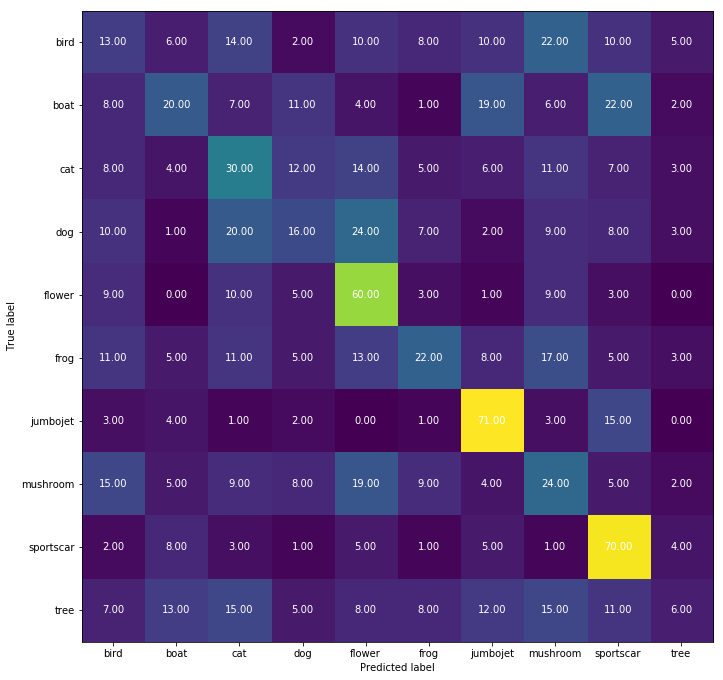

In [58]:
LABELS = [
    'bird', 'boat', 'cat', 'dog', 'flower', 'frog',
    'jumbojet', 'mushroom', 'sportscar', 'tree'
]

f, ax = plt.subplots(figsize=(10, 10))
ax.imshow(cm_test)
ax.set(
    xticks=np.arange(10),
    yticks=np.arange(10),
    xticklabels=LABELS,
    yticklabels=LABELS,
    ylabel='True label',
    xlabel='Predicted label'
)
fmt = '.2f'
for i in range(cm_test.shape[0]):
    for j in range(cm_test.shape[1]):
        ax.text(j, i, format(confusion_matrix_testset[i, j], fmt),
               ha='center', va='center', color='white')
f.tight_layout()
plt.show()